# Multivariate Time Series with RNN
---
---
Appliance Energy Usage: A Multivariate Time Series Forecasting Example

Experimental data used to create regression models of appliances energy use in a low energy building.
Data Set Information:

The data set is at 10 min for about 4.5 months. The house temperature and humidity conditions were monitored with a ZigBee wireless sensor network. Each wireless node transmitted the temperature and humidity conditions around 3.3 min. Then, the wireless data was averaged for 10 minutes periods. The energy data was logged every 10 minutes with m-bus energy meters. Weather from the nearest airport weather station (Chievres Airport, Belgium) was downloaded from a public data set from Reliable Prognosis (rp5.ru), and merged together with the experimental data sets using the date and time column. Two random variables have been included in the data set for testing the regression models and to filter out non predictive attributes (parameters).
Original source of the dataset:

http://archive.ics.uci.edu/ml/datasets/Appliances+energy+prediction
___
___

**Points to remember**
* Neural Network could be a blackbox, so it is harder to interpret i.e. what the model is doing to predict the multivariate time-series (or time series in general).
* A better interpretable alternatives would be SARIMAX and VARIMAX. So try these before jumping into RNN/LSTM

**Using multivariate timeseries will include 2 main changes**
* `n_features` used in keras before was `=1` because there was only 1 feature/time series. In case of multivariate timeseries with RNN `n_features` would be number of features in the time series
* Final dense layer was 1 in a timeseries with 1 feature, that is because we were predicting 1 value of 1 feature in the future. For multivariate time-series we are forecasting multiple variables. Thus, in case of multivariate time-series dense layer should have a neuron per feature.variable.

In [91]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

In [92]:
# IGNORE THE CONTENT OF THIS CELL
# import tensorflow as tf
# tf.compat.v1.disable_eager_execution()

## Data

Let's read in the data set:

In [93]:
df = pd.read_csv('../DATA/energydata_complete.csv',index_col='date',
                infer_datetime_format=True)

In [94]:
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-01-11 17:00:00,60,30,19.89,47.596667,19.2,44.790000,19.79,44.730000,19.000000,45.566667,...,17.033333,45.53,6.600000,733.5,92.0,7.000000,63.000000,5.3,13.275433,13.275433
2016-01-11 17:10:00,60,30,19.89,46.693333,19.2,44.722500,19.79,44.790000,19.000000,45.992500,...,17.066667,45.56,6.483333,733.6,92.0,6.666667,59.166667,5.2,18.606195,18.606195
2016-01-11 17:20:00,50,30,19.89,46.300000,19.2,44.626667,19.79,44.933333,18.926667,45.890000,...,17.000000,45.50,6.366667,733.7,92.0,6.333333,55.333333,5.1,28.642668,28.642668
2016-01-11 17:30:00,50,40,19.89,46.066667,19.2,44.590000,19.79,45.000000,18.890000,45.723333,...,17.000000,45.40,6.250000,733.8,92.0,6.000000,51.500000,5.0,45.410389,45.410389
2016-01-11 17:40:00,60,40,19.89,46.333333,19.2,44.530000,19.79,45.000000,18.890000,45.530000,...,17.000000,45.40,6.133333,733.9,92.0,5.666667,47.666667,4.9,10.084097,10.084097


In [95]:
# No missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 28 columns):
Appliances     19735 non-null int64
lights         19735 non-null int64
T1             19735 non-null float64
RH_1           19735 non-null float64
T2             19735 non-null float64
RH_2           19735 non-null float64
T3             19735 non-null float64
RH_3           19735 non-null float64
T4             19735 non-null float64
RH_4           19735 non-null float64
T5             19735 non-null float64
RH_5           19735 non-null float64
T6             19735 non-null float64
RH_6           19735 non-null float64
T7             19735 non-null float64
RH_7           19735 non-null float64
T8             19735 non-null float64
RH_8           19735 non-null float64
T9             19735 non-null float64
RH_9           19735 non-null float64
T_out          19735 non-null float64
Press_mm_hg    19735 non-null float64
RH_out         19735 non-null fl

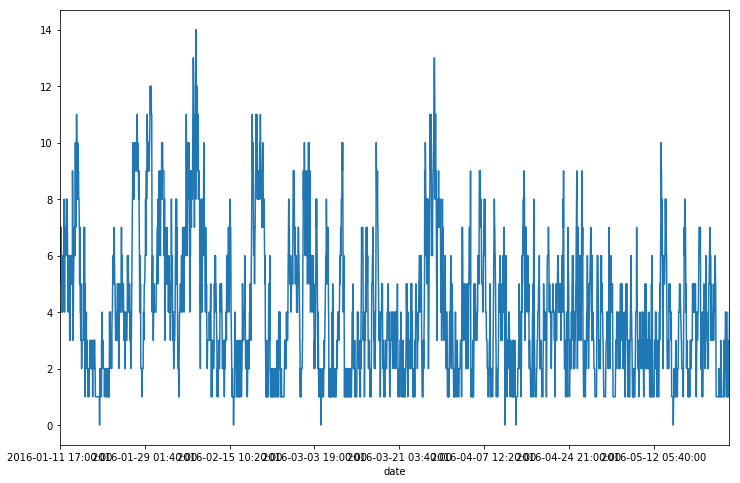

In [96]:
df['Windspeed'].plot(figsize=(12,8))

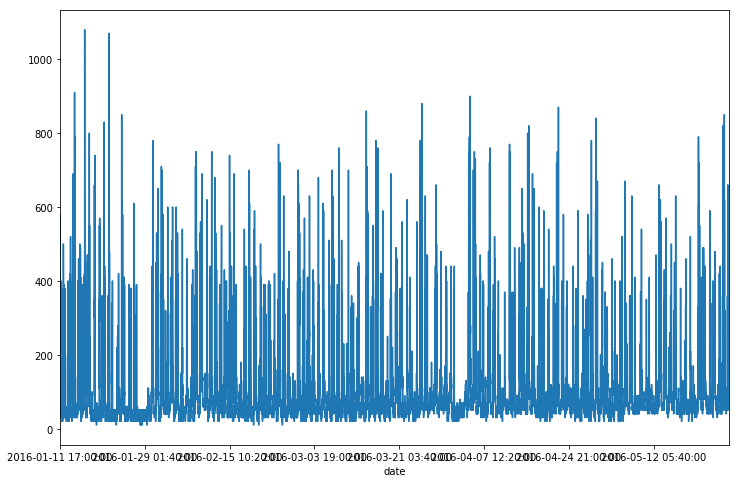

In [97]:
df['Appliances'].plot(figsize=(12,8))

## Train Test Split

In [98]:
len(df)

19735

In [100]:
df.tail(5)

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-27 17:20:00,100,0,25.566667,46.560000,25.890000,42.025714,27.200000,41.163333,24.7,45.590000,...,23.2,46.7900,22.733333,755.2,55.666667,3.333333,23.666667,13.333333,43.096812,43.096812
2016-05-27 17:30:00,90,0,25.500000,46.500000,25.754000,42.080000,27.133333,41.223333,24.7,45.590000,...,23.2,46.7900,22.600000,755.2,56.000000,3.500000,24.500000,13.300000,49.282940,49.282940
2016-05-27 17:40:00,270,10,25.500000,46.596667,25.628571,42.768571,27.050000,41.690000,24.7,45.730000,...,23.2,46.7900,22.466667,755.2,56.333333,3.666667,25.333333,13.266667,29.199117,29.199117
2016-05-27 17:50:00,420,10,25.500000,46.990000,25.414000,43.036000,26.890000,41.290000,24.7,45.790000,...,23.2,46.8175,22.333333,755.2,56.666667,3.833333,26.166667,13.233333,6.322784,6.322784
2016-05-27 18:00:00,430,10,25.500000,46.600000,25.264286,42.971429,26.823333,41.156667,24.7,45.963333,...,23.2,46.8450,22.200000,755.2,57.000000,4.000000,27.000000,13.200000,34.118851,34.118851


Let's imagine we want to predict just 24 hours into the future, we don't need 3 months of data for that, so let's save some training time and only select the last months data.

In [101]:
df = df.loc['2016-05-01':]
df.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-01 00:00:00,50,0,21.200000,38.2000,18.390000,41.40,23.200000,36.400000,19.73,37.730000,...,19.166667,38.200000,4.300000,763.700000,86.000000,2.000000,40.000000,2.200000,15.310003,15.310003
2016-05-01 00:10:00,60,0,21.150000,38.1725,18.390000,41.50,23.133333,36.466667,19.70,37.663333,...,19.133333,38.290000,4.283333,763.716667,86.333333,2.166667,38.166667,2.216667,11.240067,11.240067
2016-05-01 00:20:00,50,0,21.133333,38.0900,18.323333,41.50,23.200000,36.500000,19.70,37.590000,...,19.133333,38.363333,4.266667,763.733333,86.666667,2.333333,36.333333,2.233333,21.808814,21.808814
2016-05-01 00:30:00,50,0,21.100000,38.0900,18.290000,41.50,23.200000,36.500000,19.70,37.500000,...,19.166667,38.500000,4.250000,763.750000,87.000000,2.500000,34.500000,2.250000,47.000534,47.000534
2016-05-01 00:40:00,60,0,21.100000,38.0300,18.290000,41.56,23.200000,36.500000,19.70,37.500000,...,19.166667,38.633333,4.233333,763.766667,87.333333,2.666667,32.666667,2.266667,8.059441,8.059441


Let's also round off the data, to one decimal point precision, otherwise this may cause issues with our network (we will also normalize the data anyways, so this level of precision isn't useful to us)

In [102]:
df = df.round(2)

In [103]:
len(df)

3853

In [104]:
# How many rows per day? We know its every 10 min
24*60/10

144.0

In [105]:
test_days = 2

In [106]:
test_ind = test_days*144

In [107]:
test_ind

288

In [108]:
# Notice the minus sign in our indexing

train = df.iloc[:-test_ind]
test = df.iloc[-test_ind:]

## Scale Data

In [111]:
from sklearn.preprocessing import MinMaxScaler

In [112]:
scaler = MinMaxScaler()

In [113]:
scaler.fit(train)

scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

# Time Series Generator

This class takes in a sequence of data-points gathered at
equal intervals, along with time series parameters such as
stride, length of history, etc., to produce batches for
training/validation.

#### Arguments
    data: Indexable generator (such as list or Numpy array)
        containing consecutive data points (timesteps).
        The data should be at 2D, and axis 0 is expected
        to be the time dimension.
    targets: Targets corresponding to timesteps in `data`.
        It should have same length as `data`.
    length: Length of the output sequences (in number of timesteps).
    sampling_rate: Period between successive individual timesteps
        within sequences. For rate `r`, timesteps
        `data[i]`, `data[i-r]`, ... `data[i - length]`
        are used for create a sample sequence.
    stride: Period between successive output sequences.
        For stride `s`, consecutive output samples would
        be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`, etc.
    start_index: Data points earlier than `start_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    end_index: Data points later than `end_index` will not be used
        in the output sequences. This is useful to reserve part of the
        data for test or validation.
    shuffle: Whether to shuffle output samples,
        or instead draw them in chronological order.
    reverse: Boolean: if `true`, timesteps in each output sample will be
        in reverse chronological order.
    batch_size: Number of timeseries samples in each batch
        (except maybe the last one).

In [114]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [115]:
# define generator
# length = 144 because there are 144 rows per day
# Observation every 10 min
length = 144 
batch_size = 1 #Number of timeseries samples in each batch
generator = TimeseriesGenerator(scaled_train, scaled_train, 
                        length=length, batch_size=batch_size)

That means given 1 full day worth of information, let's forecast next observation or next 10 min (each observation is 10 mins here).

In [116]:
len(scaled_train)

3565

In [117]:
len(generator) 

3421

In [118]:
3565-3421

144

In [119]:
# scaled_train

In [122]:
# What does the first batch look like?
X,y = generator[0]

In [124]:
print(f'Given the Array:{X.flatten()}\n\n')
print(f'Predict this y:{y}')

Given the Array:[0.03896104 0.         0.13798978 ... 0.14319527 0.75185111 0.75185111]


Predict this y:[[0.03896104 0.         0.30834753 0.29439421 0.16038492 0.49182278
  0.0140056  0.36627907 0.24142857 0.24364791 0.12650602 0.36276002
  0.12       0.28205572 0.06169297 0.15759185 0.34582624 0.39585974
  0.09259259 0.39649608 0.18852459 0.96052632 0.59210526 0.1
  0.58333333 0.13609467 0.4576746  0.4576746 ]]


`Given the array` contains 144 observation for each feature. And `y` contains 1 observation for each feature.

Now you will be able to edit the length so that it makes sense for your time series!

### Create the Model

In [125]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,LSTM

In [126]:
scaled_train.shape

(3565, 28)

In [127]:
# define model
model = Sequential()

# Simple RNN layer
# UNIVARIATE analysis: n_features was 1 (1 column predicting) 
# In MULTIVARIATE: input_shape should include no. of features
# Length = 144 | scaled_train.shape[1] = Number of columns
model.add(LSTM(100,input_shape=(length,scaled_train.shape[1])))

# Final Prediction (one neuron per feature)
# UNIVARIATE analysis: Dense layer contained 1 neuron
# In MULTIVARIATE: Dense layer contained n neuron
# where n is no. of features
model.add(Dense(scaled_train.shape[1]))

model.compile(optimizer='adam', loss='mse')

In [128]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               51600     
_________________________________________________________________
dense_1 (Dense)              (None, 28)                2828      
Total params: 54,428
Trainable params: 54,428
Non-trainable params: 0
_________________________________________________________________


## EarlyStopping

In [88]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',patience=1)

validation_generator = TimeseriesGenerator(scaled_test,scaled_test, 
                                length=length, batch_size=batch_size)

In [130]:
model.fit_generator(generator,epochs=5, # Increase epochs to 10
                    validation_data=validation_generator,
                   callbacks=[early_stop])

Epoch 1/5
3421/3421 [==============================] - 9531s 3s/step - loss: 0.0111 - val_loss: 0.0101
Epoch 2/5
3421/3421 [==============================] - 14438s 4s/step - loss: 0.0080 - val_loss: 0.0093
Epoch 3/5
3421/3421 [==============================] - 10266s 3s/step - loss: 0.0075 - val_loss: 0.0088
Epoch 4/5
3421/3421 [==============================] - 9414s 3s/step - loss: 0.0074 - val_loss: 0.0082
Epoch 5/5
3421/3421 [==============================] - 8711s 3s/step - loss: 0.0072 - val_loss: 0.0079


In [131]:
model.history.history.keys()

dict_keys(['loss', 'val_loss'])

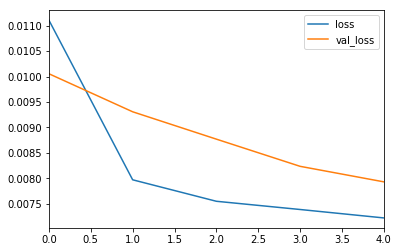

In [132]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [133]:
# As both are going down we should train for more epochs

## Evaluate on Test Data

In [134]:
first_eval_batch = scaled_train[-length:]

In [135]:
first_eval_batch

array([[0.1038961 , 0.        , 0.72231687, ..., 0.53550296, 0.15909546,
        0.15909546],
       [0.11688312, 0.        , 0.73424191, ..., 0.52662722, 0.40344207,
        0.40344207],
       [0.11688312, 0.        , 0.73424191, ..., 0.51775148, 0.20452271,
        0.20452271],
       ...,
       [0.18181818, 0.        , 0.70017036, ..., 0.50118343, 0.33340004,
        0.33340004],
       [0.09090909, 0.        , 0.70017036, ..., 0.51952663, 0.78747248,
        0.78747248],
       [0.1038961 , 0.        , 0.70017036, ..., 0.53846154, 0.77286372,
        0.77286372]])

In [136]:
first_eval_batch = first_eval_batch.reshape((1, length, scaled_train.shape[1]))

In [137]:
model.predict(first_eval_batch)

array([[ 1.13671616e-01, -8.49337503e-03,  7.00345576e-01,
         4.10412490e-01,  5.72248220e-01,  4.40570712e-01,
         4.31980610e-01,  4.24183816e-01,  7.07729399e-01,
         4.04827654e-01,  3.15280050e-01,  3.87151271e-01,
         6.46061599e-01, -3.45919281e-04,  6.27590775e-01,
         4.24994320e-01,  5.37227392e-01,  3.38887990e-01,
         5.43015242e-01,  3.79956365e-01,  6.30288005e-01,
         5.36718130e-01,  4.29036289e-01,  2.19722122e-01,
         5.77410638e-01,  5.50318658e-01,  4.37128216e-01,
         4.36259031e-01]], dtype=float32)

In [138]:
scaled_test[0]

array([0.19480519, 0.        , 0.70017036, 0.3920434 , 0.53007217,
       0.41064526, 0.40616246, 0.41913319, 0.72714286, 0.4115245 ,
       0.30722892, 0.36445121, 0.66777778, 0.        , 0.61119082,
       0.39840637, 0.51618399, 0.32953105, 0.53703704, 0.34024896,
       0.6057377 , 0.52631579, 0.41881579, 0.2       , 0.55283333,
       0.53372781, 0.76305783, 0.76305783])

Now let's put this logic in a for loop to predict into the future for the entire test range.

----

**NOTE: PAY CLOSE ATTENTION HERE TO WHAT IS BEING OUTPUTED AND IN WHAT DIMENSIONS. ADD YOUR OWN PRINT() STATEMENTS TO SEE WHAT IS TRULY GOING ON!!**

In [139]:
n_features = scaled_train.shape[1]
test_predictions = []

first_eval_batch = scaled_train[-length:]
current_batch = first_eval_batch.reshape((1, length, n_features))

for i in range(len(test)):
    
    # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
    current_pred = model.predict(current_batch)[0]
    
    # store prediction
    test_predictions.append(current_pred) 
    
    # update batch to now include prediction and drop first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [140]:
test_predictions

[array([ 1.13671616e-01, -8.49337503e-03,  7.00345576e-01,  4.10412490e-01,
         5.72248220e-01,  4.40570712e-01,  4.31980610e-01,  4.24183816e-01,
         7.07729399e-01,  4.04827654e-01,  3.15280050e-01,  3.87151271e-01,
         6.46061599e-01, -3.45919281e-04,  6.27590775e-01,  4.24994320e-01,
         5.37227392e-01,  3.38887990e-01,  5.43015242e-01,  3.79956365e-01,
         6.30288005e-01,  5.36718130e-01,  4.29036289e-01,  2.19722122e-01,
         5.77410638e-01,  5.50318658e-01,  4.37128216e-01,  4.36259031e-01],
       dtype=float32),
 array([ 1.1593731e-01, -1.6186614e-02,  7.0866221e-01,  4.2491081e-01,
         5.9034491e-01,  4.5030767e-01,  4.3537152e-01,  4.3453962e-01,
         7.0950985e-01,  4.1746280e-01,  3.3740285e-01,  4.2296448e-01,
         6.3793534e-01, -4.9541891e-04,  6.4018333e-01,  4.4931886e-01,
         5.4943413e-01,  3.6297256e-01,  5.5111891e-01,  4.0921149e-01,
         6.2947631e-01,  5.3535390e-01,  4.3752569e-01,  2.3670468e-01,
         5.5

In [141]:
scaled_test

array([[0.19480519, 0.        , 0.70017036, ..., 0.53372781, 0.76305783,
        0.76305783],
       [0.37662338, 0.        , 0.70017036, ..., 0.52840237, 0.62337402,
        0.62337402],
       [0.12987013, 0.        , 0.70017036, ..., 0.52366864, 0.08785271,
        0.08785271],
       ...,
       [0.32467532, 0.33333333, 0.87052811, ..., 0.86804734, 0.58415049,
        0.58415049],
       [0.51948052, 0.33333333, 0.87052811, ..., 0.86568047, 0.12627577,
        0.12627577],
       [0.53246753, 0.33333333, 0.87052811, ..., 0.86390533, 0.68260957,
        0.68260957]])

## Inverse Transformations and Compare

In [142]:
true_predictions = scaler.inverse_transform(test_predictions)

In [143]:
true_predictions

array([[107.5271441 ,  -0.25480125,  24.50102853, ...,   7.90038533,
         21.85329695,  21.80986379],
       [109.27172676,  -0.48559841,  24.54984718, ...,   8.17058038,
         21.89501304,  22.07723276],
       [111.58830598,  -0.70553955,  24.58411296, ...,   8.41075634,
         21.98684294,  22.31139208],
       ...,
       [158.80951881,   0.80404138,  25.11768444, ...,  19.61957405,
         26.90414693,  27.6539464 ],
       [158.80948439,   0.80403926,  25.11768654, ...,  19.619568  ,
         26.90414395,  27.6539464 ],
       [158.80946144,   0.80403775,  25.11768863, ...,  19.61956397,
         26.90414693,  27.65394044]])

In [144]:
test.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
date,,,,,,,,,,,,,,,,,,,,,
2016-05-25 18:10:00,170,0,24.50,37.86,24.00,34.27,25.00,36.70,24.29,37.79,...,22.00,37.23,16.48,756.1,55.83,2.0,38.17,7.62,38.14,38.14
2016-05-25 18:20:00,310,0,24.50,37.30,23.86,34.33,24.94,36.67,24.29,37.79,...,22.00,37.36,16.47,756.1,55.67,2.0,36.33,7.53,31.16,31.16
2016-05-25 18:30:00,120,0,24.50,36.96,23.73,34.33,24.85,36.50,24.29,37.79,...,22.03,37.39,16.45,756.1,55.50,2.0,34.50,7.45,4.40,4.40
2016-05-25 18:40:00,120,0,24.50,37.00,23.70,34.40,24.84,36.45,24.29,37.90,...,22.10,37.72,16.43,756.1,55.33,2.0,32.67,7.37,27.12,27.12
2016-05-25 18:50:00,120,0,24.49,37.07,23.68,34.52,24.84,36.49,24.28,37.93,...,22.10,37.81,16.42,756.1,55.17,2.0,30.83,7.28,10.27,10.27


In [146]:
true_predictions = pd.DataFrame(data=true_predictions,columns=test.columns)

In [147]:
true_predictions.head()

,Appliances,lights,T1,RH_1,T2,RH_2,T3,RH_3,T4,RH_4,...,T9,RH_9,T_out,Press_mm_hg,RH_out,Windspeed,Visibility,Tdewpoint,rv1,rv2
0,107.527144,-0.254801,24.501029,38.367905,24.525935,35.276393,25.184342,36.795558,24.154106,37.642402,...,22.032282,38.091254,17.079027,756.337173,56.606758,2.197221,39.644638,7.900385,21.853297,21.809864
1,109.271727,-0.485598,24.549847,38.768784,24.751601,35.603847,25.208553,36.991490,24.166569,37.920880,...,22.076042,38.725797,17.059222,756.306069,57.251952,2.367047,38.269552,8.170580,21.895013,22.077233
2,111.588306,-0.705540,24.584113,39.157296,24.885462,35.870410,25.248944,37.195553,24.195684,38.294214,...,22.120038,39.346113,17.027552,756.247425,58.034864,2.517116,36.620913,8.410756,21.986843,22.311392
3,113.762110,-0.855517,24.617376,39.536724,24.992484,36.193333,25.298503,37.436109,24.249362,38.682964,...,22.169946,39.939863,17.019410,756.206637,58.905480,2.667394,35.169623,8.650847,22.095726,22.509268
4,115.901630,-0.946792,24.649412,39.908390,25.066084,36.546046,25.355270,37.690383,24.311649,39.083663,...,22.223857,40.508878,17.009900,756.170257,59.819428,2.809911,33.911297,8.884575,22.202875,22.685014


In [148]:
# we can calculate RMSE here

## EXTRA:
### Our Saved Model

In [149]:
from tensorflow.keras.models import load_model

In [150]:
model.save("multivariate.h5")